## Model 2: Logistic Regression + Count Vectorizer, $n$ = 4537 

* <i><b>Logistic Regression: </b>More Data</i> 
* Random Forests
* Naïve Bayes
* SVM

#### Model Performance Summary: 

Both estimators trained models that preformed surprisingly well for the data provided, the stopwords and the lack of hyperparameter tuning over a gridsearch. 

Model   | Transformer       | Classifier            | $n$  | x-val   | Train    | Test   |  Precision    | Specificity   | Recall
---     |---                | ---                   | ---  | ---     | ---      | ---    |  ---          | ---           | ---
1       | Count Vectorizer  | Logistic Regressor    | 2605 | 0.7373  | 0.9723   | 0.7515 | 0.7436        | 0.7179        | 0.7838 
2       | Count Vectorizer  | Logistic Regressor    | 4537 | 0.7111  | 0.9568   | 0.7436 | 0.7527        |  0.7496       | 0.7396

In [73]:
##### BASIC IMPORTS 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##### MODELLING IMPORTS 
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

##### VECTOR MODELLING IMPORTS 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text   # TO MODIFY STOP WORDS 

In [37]:
# CUSTOM IMPORTS AND SETTINGS 
plt.style.use('gstyle.mplstyle')                        # stylesheet for sns
color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',         # colorlist, color blind pallet
                  '#f781bf', '#a65628', '#984ea3',      # from gist.github.com/thriveth/8560036
                  '#999999', '#e41a1c', '#dede00']

sns.set_palette(sns.color_palette(color_cycle))         # setting custom palette

pd.options.display.max_columns = 90                     # view settings
pd.options.display.max_rows = 100

In [38]:
df = pd.read_csv('../data/reddit2000.csv')
df.shape

(5567, 2)

### CLEANING & PREPROCESSING

In [40]:
df.rename(columns = {'0': 'corpus'}, inplace=True)          # rename column 0 column to dictionary 
df.drop_duplicates(inplace = True)                          # drop duplicates 
df.dropna(axis=0, inplace = True)                           # drop all nulls
df.shape

(4537, 2)

In [41]:
# removing link strings, newline characters
df['corpus'] = df['corpus'].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('\n\n\S+', '', regex=True)

# removing non-alpha characters, which will also eliminate some model #s and model-specific identifiers
df['corpus'] = df['corpus'].replace(r"[^a-zA-Z ]", '', regex = True)

# convert to lower case
df['corpus'] = df['corpus'].str.lower()

In [47]:
# exporting cleaned file for future import into separate models ? 
df.to_csv('../data/reddit_2000_clean.csv', index = False)
df.shape

(4537, 2)

## MODELING

In [48]:
# start X, y 
# NOTE: CountVectorizer requires a vector, so make sure you set X to be a pandas Series, not a DataFrame.
X = df['corpus']
y = df['class']

In [49]:
# find baseline accuracy
y.value_counts(normalize = True)  

1    0.507384
0    0.492616
Name: class, dtype: float64

In [50]:
# train-test split
# can use "class_weights = " if we want 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

### STOP WORDS
Setting up custom `stop_words` list to ensure subreddit title and closely-associated terms are not used in model. 

In [52]:
reddit_stopwords = [ 'porsche', 'tesla', 'taycan', 'model', 'car', 'xplaid', 'turbo', 'http', 'https', 'com', 'elon', 'musk']
stopwords = text.ENGLISH_STOP_WORDS.union(reddit_stopwords)

#### Count Vector Setup to Assess Dimensionality

In [53]:
# Instantiate a CountVectorizer
cvec = CountVectorizer(stop_words=stopwords)
# Fit & transform the vectorizer on our training corpus.
Xcvec_train = cvec.fit_transform(X_train)

In [54]:
# Transform the test corpus.
Xcvec_test = cvec.transform(X_test)
Xcvec_train.shape, Xcvec_test.shape 

((3402, 8135), (1135, 8135))

#### Preliminary Visualization

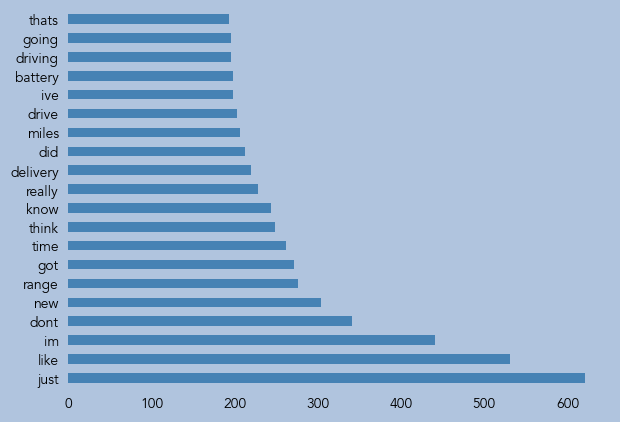

In [55]:
Xcv_train_df = pd.DataFrame(Xcvec_train.todense(), 
                          columns=cvec.get_feature_names())
Xcv_train_df.head()

#plot top occuring words
f, ax = plt.subplots(figsize=(7,5))
ax.tick_params(bottom=False, left = False)  # remove the ticks

Xcv_train_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', color = "steelblue" );

(sns.despine(left=True, bottom=True))

#### Grid and Pipe Setup, Fit, Score

In [57]:
pipe = Pipeline([                                                   # Instantiate
    ('cvec', CountVectorizer(stop_words = stopwords)),              # 1. CountVectorizer (transformer)
    ('model', LogisticRegression(max_iter = 1000))                  # 2. Logistic Regression (estimator)
])

In [58]:
# FIT model
pipe.fit(X_train, y_train);        

In [59]:
### all accuracy metrics 
x= ['x-val', 'RF Train', 'RF Test']
model_mets = [ 
    cross_val_score(pipe, X_train, y_train, cv=3).mean(),   # estimate with x-val
    pipe.score(X_train, y_train),                           # train score 
    pipe.score(X_test, y_test)                              # test score 
     ]
model_mets

[0.7116402116402117, 0.9567901234567902, 0.7444933920704846]

In [16]:
#pipe.best_estimator_.named_steps.get_params()
#gs.best_estimator_.named_steps.get_params()
#pipe.get_params()

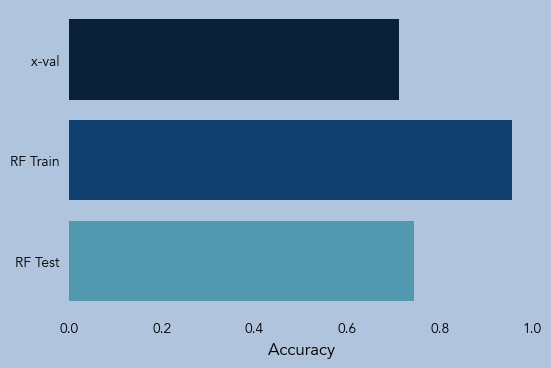

In [60]:
f, ax = plt.subplots(figsize=(6, 4))
ax.tick_params(bottom=False, left = False)  # remove the ticks
plt.xlabel('Accuracy')

sns.despine(left=True, bottom=True)
sns.barplot(y = x, x = model_mets, palette='ocean')
plt.show()

In [85]:
# Get predictions
preds = pipe.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [84]:
# precision, specificity, recall 
class_mets = [
    round(tp/(tp + fp), 4),
    round(tn/(tn + fp), 4), 
    round(tp/(tp + fn), 4)
]
class_mets

# lower recall means fewer Teslas were correcctly IDed, and slightly higher specificity shows better classification for Taycan

[0.7527, 0.7496, 0.7396]

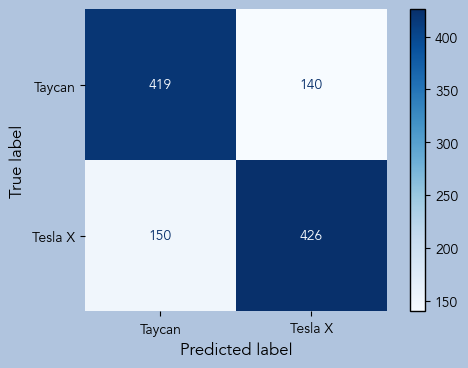

In [62]:
sub_1 = "Tesla X"
sub_2 = "Taycan"

plot_confusion_matrix(pipe, X_test, y_test, cmap = 'Blues', display_labels = [sub_2, sub_1]);
(sns.despine(left=True, bottom=True))

In [63]:
mask = (y_test != preds) & (preds == 0)
false_negatives = pd.DataFrame(X_test[mask])

# exporting missed comments to analyse
df.to_csv('../data/missed02.txt', index = False)

false_negatives[:40]

,corpus
1973,the milage is never actuate anyway i got a x ...
1263,same order time but i still have september for...
1624,wasnt there a quote from tesla that they were ...
236,my god are you in heaven rn
42,cad usd would be about cad d
647,no one knows for sure theres nothing wrong wit...
189,yep still happening and got several inches of ...
1780,nope i thought it might be because we have th...
1094,this couldnt agree with this more
1223,im assuming its a hv wiring harness to the mot...


#### Model Performance

Model   | Transformer       | Classifier            | $n$  | x-val   | Train    | Test   |  Precision    | Specificity   | Recall
---     |---                | ---                   | ---  | ---     | ---      | ---    |  ---          | ---           | ---
1       | Count Vectorizer  | Logistic Regressor    | 2605 | 0.7373  | 0.9723   | 0.7515 | 0.7436        | 0.7179        | 0.7838 
2       | Count Vectorizer  | Logistic Regressor    | 4537 | 0.7111  | 0.9568   | 0.7436 | 0.7527        |  0.7496       | 0.7396

## Creating Visalizations of Word Counts

In [64]:
# make new cvec for class 0 
# make new cvec for class 1 

c0 = df[df['class'] == 0 ]
c1 = df[df['class'] == 1 ]

In [65]:

c0 = df[df['class'] == 0 ]
c1 = df[df['class'] == 1 ]

x0 = c0['corpus']
y0 = c0['class']

x1 = c1['corpus']
y1 = c1['class']

# Instantiate a CountVectorizer
cvec0 = CountVectorizer(stop_words = stopwords)
cvec1 = CountVectorizer(stop_words = stopwords)

# Fit & transform the vectorizer on our training corpus.
cv0 = cvec0.fit_transform(x0)
cv1 = cvec1.fit_transform(x1)

In [68]:
# Transform the test corpus.
cv0 = cvec0.transform(x0)
cv1 = cvec1.transform(x1)

# make dense array
cv0 = pd.DataFrame(cv0.todense(), columns=cvec0.get_feature_names())
cv1 = pd.DataFrame(cv1.todense(), columns=cvec1.get_feature_names())

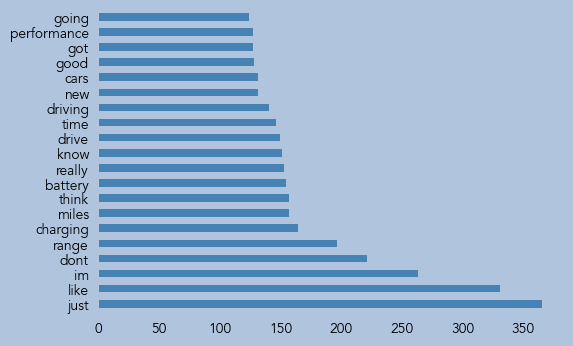

In [33]:
#plot top occuring words, class 0 = taycan
f, ax = plt.subplots(figsize=(6,4))
ax.tick_params(bottom=False, left = False)  # remove the ticks

cv0.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', color = "steelblue" );

(sns.despine(left=True, bottom=True))

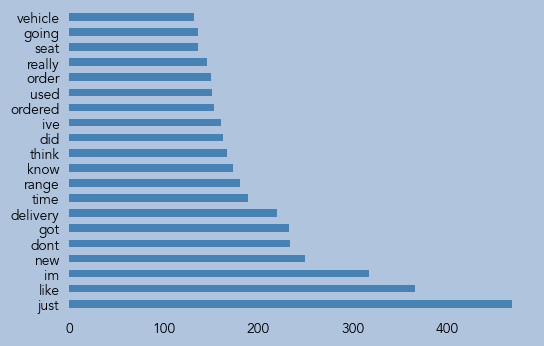

In [34]:
#plot top occuring words, class 1 = model x
f, ax = plt.subplots(figsize=(6,4))
ax.tick_params(bottom=False, left = False)  # remove the ticks

cv1.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', color = "steelblue" );

(sns.despine(left=True, bottom=True))

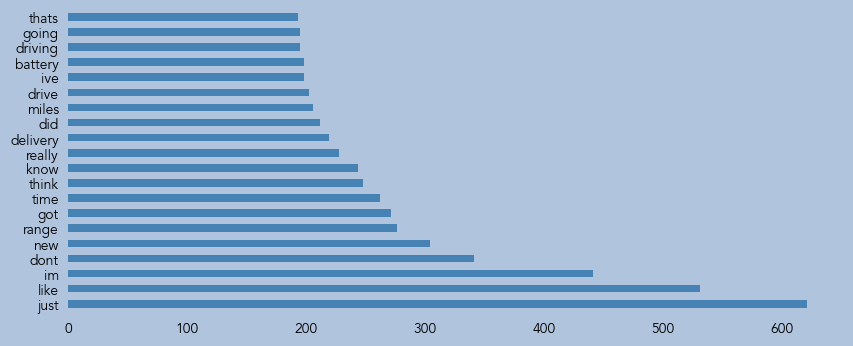

In [69]:
#plot top occuring words, overall

cvec = CountVectorizer(stop_words=stopwords)
Xcvec_train = cvec.fit_transform(X_train)

Xcvec_test = cvec.transform(X_test)
Xcvec_train.shape, Xcvec_test.shape 
Xcv_train_df = pd.DataFrame(Xcvec_train.todense(), columns=cvec.get_feature_names())
Xcv_train_df.head()

f, ax = plt.subplots(figsize=(10,4))
ax.tick_params(bottom=False, left = False)  # remove the ticks

Xcv_train_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', color = "steelblue" );

(sns.despine(left=True, bottom=True))